In [33]:
import class_function as cf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
data = pd.read_csv('../Data/result_iv_selected.csv')
X = data.drop(columns=['TARGET'])
Y = data.TARGET

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [60]:
class Multi_XGB(object):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        pass
    
    def train(self, x_train, y_train):
        data = pd.concat([x_train, y_train], axis=1)
        group_result = data.groupby(y_train.name)
        data_0 = group_result.get_group(0)
        data_1 = group_result.get_group(1)
        #0比1多
        im_dergee = int(data_0.shape[0]/data_1.shape[0])
        self.im_dergee = im_dergee
        data_list = []
        maj_number = data_0.shape[0]
        balanced_number = data_1.shape[0]
        for i in range(im_dergee):
            if i < im_dergee - 1:
                data_list.append(data_0.iloc[i*balanced_number:(i+1)*balanced_number, :])
            else:
                data_list.append(data_0.iloc[i*balanced_number:, :])
        
        #print(data_list[0])
                
        xgb_cla_list = []
        for i in range(im_dergee):
            x_y = pd.concat([data_list[i], data_1], axis=0)
            #print(x_y)
            x_train_ = x_y.iloc[:, :x_y.shape[1]-1]
            y_train_ = x_y.iloc[:, x_y.shape[1]-1]
            #print(y_train_)
            xgb_cla_list.append(xgb.XGBClassifier(**self.kwargs))
            xgb_cla_list[i].fit(x_train_, y_train_)
            print('*' * 40)
            print(xgb_cla_list[i].classes_)
        
        self.xgb_cla_list = xgb_cla_list
        
    def predict(self, x_test, threshold):
        xgb_cla_list = self.xgb_cla_list
        predict_proba_list = []
        for i in range(self.im_dergee):
            predict_proba = xgb_cla_list[i].predict_proba(x_test)
            predict_proba_1 = []
            for j in range(len(predict_proba)):
                predict_proba_1.append(predict_proba[j][1])
                
            predict_proba_list.append(predict_proba_1)
            
        predict_proba = []
        result = []
        for i in range(len(predict_proba_list[0])):
            tmp = 0
            for j in range(len(predict_proba_list)):
                tmp += predict_proba_list[j][i]
            
            proba = tmp / self.im_dergee
            predict_proba.append(proba)
            if proba > threshold:
                result.append(1)
            else:
                result.append(0)
        
        self.predict_proba = predict_proba
        self.result = result
        

In [76]:
multi_xgb = Multi_XGB(max_depth=10, n_estimators=500, random_state=0, colsample_bylevel = 0.2, n_jobs = 8)
multi_xgb.train(x_train, y_train)

****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]


In [77]:
multi_xgb.predict(x_test, 0.6)
multi_xgb.result[:5]

[1, 0, 1, 0, 1]

In [78]:
multi_xgb.predict_proba

[0.9174212867563422,
 0.1975937776944854,
 0.6721237139268355,
 0.3790512139146978,
 0.8848387653177435,
 0.6872260137037798,
 0.1333873448046771,
 0.5952790704640475,
 0.019981906241313976,
 0.37825977124951105,
 0.19323113492944025,
 0.6460289304906671,
 0.29815719479864294,
 0.13484918732534756,
 0.3618494218046015,
 0.22022418677806854,
 0.16177817705002698,
 0.25706086917357013,
 0.3236920163035393,
 0.053810726004568016,
 0.20001393861391328,
 0.4039168046279387,
 0.09927859479053454,
 0.5126748735254462,
 0.5715366520664908,
 0.24348477883772415,
 0.33501027524471283,
 0.40629550272768195,
 0.07758935811844739,
 0.18824806267564947,
 0.11454586447639899,
 0.4346248209476471,
 0.907577861439098,
 0.8997023213993419,
 0.5163366902958263,
 0.6242377812212164,
 0.04002189145169475,
 0.3691124685785987,
 0.6725170422684063,
 0.6038326810706746,
 0.04927307248792865,
 0.6959402777931907,
 0.7914873144843362,
 0.2700103507800536,
 0.4117326411333951,
 0.537003370848569,
 0.566546079787

In [79]:
fbc = cf.For_binary_classifier(multi_xgb.result, y_test)

                    Real +          Real -     
   Predict +         2932            12007     
   Predict -         1923            44641     

准确率： 0.7735069833991838
召回率： 0.603913491246138
精准率： 0.1962648102282616

漏警率： 0.396086508753862
虚警率： 0.8037351897717384
F1: 0.29625138930989187
fpr: 0.21195805677164242


In [80]:
threshold_list = np.arange(0, 1, 0.01)
accuracy_list = []
recall_list = []
precision_list = []
MissingAlarm_list = []
FalseAlarm_list = []
F1_list = []
fpr_list = []

y_proba = multi_xgb.predict_proba
for threshold in threshold_list:
    #y_predicted = multi_xgb.predict(x_test, threshold)
    y_predicted = []
    
    for proba in y_proba:
        if proba > threshold:
            y_predicted.append(1)
        else:
            y_predicted.append(0)
            
    fbc = cf.For_binary_classifier(y_predicted, y_test)
    accuracy_list.append(fbc.accuracy)
    recall_list.append(fbc.recall)
    precision_list.append(fbc.precision)
    MissingAlarm_list.append(fbc.MissingAlarm)
    FalseAlarm_list.append(fbc.FalseAlarm)
    F1_list.append(fbc.F1)
    fpr_list.append(fbc.fpr)
    print('*' * 40)
    

                    Real +          Real -     
   Predict +         4855            56648     
   Predict -           0               0       

准确率： 0.0789392387363218
召回率： 1.0
精准率： 0.0789392387363218

漏警率： 0.0
虚警率： 0.9210607612636782
F1: 0.1463274963079056
fpr: 1.0
****************************************
                    Real +          Real -     
   Predict +         4855            56371     
   Predict -           0              277      

准确率： 0.08344308407719948
召回率： 1.0
精准率： 0.07929637735602522

漏警率： 0.0
虚警率： 0.9207036226439748
F1: 0.14694087559207641
fpr: 0.9951101539330603
****************************************
                    Real +          Real -     
   Predict +         4849            55609     
   Predict -           6             1039      

准确率： 0.09573516739020861
召回率： 0.9987641606591143
精准率： 0.08020443944556552

漏警率： 0.0012358393408856694
虚警率： 0.9197955605544345
F1: 0.1484849876747355
fpr: 0.9816586640305042
****************************************
     

                    Real +          Real -     
   Predict +         4352            32952     
   Predict -          503            23696     

准确率： 0.4560427946604231
召回率： 0.8963954685890834
精准率： 0.11666309242976625

漏警率： 0.10360453141091663
虚警率： 0.8833369075702338
F1: 0.2064565098792666
fpr: 0.5816975003530575
****************************************
                    Real +          Real -     
   Predict +         4320            32211     
   Predict -          535            24437     

准确率： 0.46757068760873455
召回率： 0.8898043254376931
精准率： 0.11825572801182557

漏警率： 0.11019567456230694
虚警率： 0.8817442719881744
F1: 0.2087662494563379
fpr: 0.5686167208021465
****************************************
                    Real +          Real -     
   Predict +         4285            31413     
   Predict -          570            25235     

准确率： 0.4799765865079752
召回率： 0.88259526261586
精准率： 0.12003473583954283

漏警率： 0.11740473738414003
虚警率： 0.8799652641604572
F1: 0.211328385076319

                    Real +          Real -     
   Predict +         3463            17756     
   Predict -         1392            38892     

准确率： 0.6886655935482822
召回率： 0.7132852729145212
精准率： 0.16320278995240114

漏警率： 0.28671472708547885
虚警率： 0.8367972100475989
F1: 0.2656285955357828
fpr: 0.313444428753001
****************************************
                    Real +          Real -     
   Predict +         3424            17225     
   Predict -         1431            39423     

准确率： 0.6966652033234151
召回率： 0.7052523171987641
精准率： 0.16581916799845028

漏警率： 0.29474768280123587
虚警率： 0.8341808320015497
F1: 0.2685069008782936
fpr: 0.30407075271854256
****************************************
                    Real +          Real -     
   Predict +         3387            16721     
   Predict -         1468            39927     

准确率： 0.7042583288620067
召回率： 0.6976313079299691
精准率： 0.16844042172269744

漏警率： 0.3023686920700309
虚警率： 0.8315595782773025
F1: 0.271361615190481

                    Real +          Real -     
   Predict +         2214            7139      
   Predict -         2641            49509     

准确率： 0.8409833666650407
召回率： 0.4560247167868177
精准率： 0.236715492355394

漏警率： 0.5439752832131823
虚警率： 0.763284507644606
F1: 0.31165540540540543
fpr: 0.1260238666854964
****************************************
                    Real +          Real -     
   Predict +         2150            6768      
   Predict -         2705            49880     

准确率： 0.845974993089768
召回率： 0.4428424304840371
精准率： 0.24108544516707783

漏警率： 0.557157569515963
虚警率： 0.7589145548329221
F1: 0.3122050388441153
fpr: 0.11947465047309702
****************************************
                    Real +          Real -     
   Predict +         2084            6410      
   Predict -         2771            50238     

准确率： 0.8507227289725704
召回率： 0.42924819773429457
精准率： 0.24534965858252886

漏警率： 0.5707518022657054
虚警率： 0.7546503414174711
F1: 0.3122331260768597
fp

                    Real +          Real -     
   Predict +          251             297      
   Predict -         4604            56351     

准确率： 0.9203128302684422
召回率： 0.05169927909371782
精准率： 0.458029197080292

漏警率： 0.9483007209062821
虚警率： 0.541970802919708
F1: 0.0929113455487692
fpr: 0.005242903544697077
****************************************
                    Real +          Real -     
   Predict +          160             167      
   Predict -         4695            56481     

准确率： 0.9209469456774466
召回率： 0.032955715756951595
精准率： 0.4892966360856269

漏警率： 0.9670442842430484
虚警率： 0.5107033639143731
F1: 0.061752219220378234
fpr: 0.002948029939274114
****************************************
                    Real +          Real -     
   Predict +          79              78       
   Predict -         4776            56570     

准确率： 0.9210770206331399
召回率： 0.01627188465499485
精准率： 0.5031847133757962

漏警率： 0.9837281153450051
虚警率： 0.4968152866242038
F1: 0.031524341580

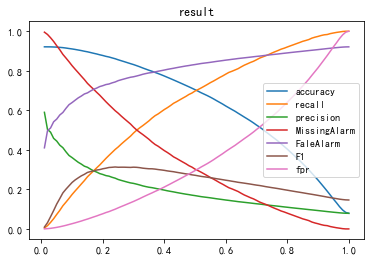

In [81]:
x_list = 1 - np.arange(0, 1, 0.01)
plt.title('result')
plt.plot(x_list, accuracy_list, label='accuracy')
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, precision_list, label='precision')
plt.plot(x_list, MissingAlarm_list, label='MissingAlarm')
plt.plot(x_list, FalseAlarm_list, label='FaleAlarm')
plt.plot(x_list, F1_list, label='F1')
plt.plot(x_list, fpr_list, label='fpr')
plt.legend()
plt.show()

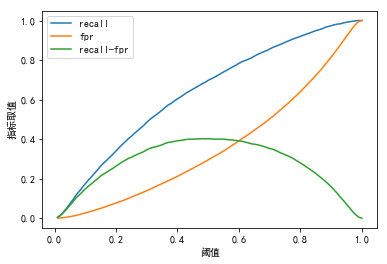

In [86]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, fpr_list, label='fpr')
plt.plot(x_list, [recall_list[i] - fpr_list[i] for i in range(len(recall_list))], label='recall-fpr')
plt.legend()
plt.xlabel('阈值')
plt.ylabel('指标取值')
plt.show()

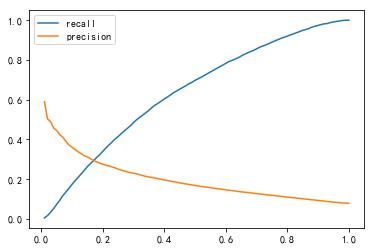

In [83]:
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, precision_list, label='precision')
plt.legend()
plt.show()

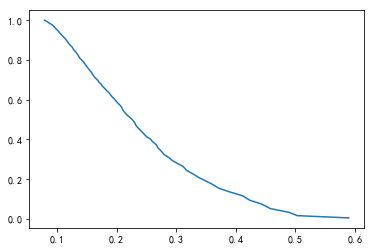

In [84]:
plt.plot(precision_list, recall_list, label='precision')
plt.show()

In [85]:
K_S = max([recall_list[i] - fpr_list[i] for i in range(len(recall_list))])
print(K_S)
np.argmax([recall_list[i] - fpr_list[i] for i in range(len(recall_list))])

0.40245760365091243


50

In [74]:
accuracy_list[50]

0.7036729915613873

In [72]:
X.columns

Index(['pre_app_merged_NAME_PAYMENT_TYPE_Cash through the bank',
       'bureau_merged_DAYS_ENDDATE_FACT_max',
       'pre_app_merged_NAME_CONTRACT_STATUS_Approved',
       'bureau_merged_DAYS_ENDDATE_FACT_mean',
       'pre_app_merged_CODE_REJECT_REASON_SCOFR', 'AMT_ANNUITY',
       'pre_app_merged_DAYS_LAST_DUE_1ST_VERSION_std',
       'pre_app_merged_installments_DAYS_INSTALMENT_min_std', 'TOTALAREA_MODE',
       'EXT_SOURCE_3', 'pre_app_merged_DAYS_LAST_DUE_mean', 'DAYS_ID_PUBLISH',
       'pre_app_merged_PRODUCT_COMBINATION_Cash X-Sell: low',
       'pre_app_merged_PRODUCT_COMBINATION_POS industry with interest',
       'EXT_SOURCE_2', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'pre_app_merged_NAME_CLIENT_TYPE_New',
       'pre_app_merged_NAME_CONTRACT_TYPE_Consumer loans',
       'pre_app_merged_CNT_PAYMENT_min',
       'pre_app_merged_PRODUCT_COMBINATION_Card Street',
       'pre_app_merged_DAYS_FIRST_DRAWING_min',
       'pre_app_merged_NAME_CONTRACT_TYPE_Revolving loan

In [73]:
X.dtypes.value_counts()

float64    53
int64      12
dtype: int64